# Importing Libraries

In [1]:
# General Libraries
import os  # For handling file paths
import random  # For generating random values
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting visualizations
from tqdm import tqdm  # For displaying progress bars

# TensorFlow/Keras Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For data preprocessing and augmentation
from tensorflow.keras.models import Sequential, Model  # For defining models
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, concatenate  # For layers
from tensorflow.keras.callbacks import EarlyStopping  # For stopping training early

# Image Processing
import cv2  # For image reading and preprocessing

# Performance Evaluation
from sklearn.metrics import (
    confusion_matrix,  # For confusion matrix calculations
    ConfusionMatrixDisplay,  # For displaying confusion matrices
    classification_report  # For detailed performance evaluation
)

# Statistical Testing
from scipy.stats import (
    ttest_rel,  # Paired t-test
    wilcoxon,  # Wilcoxon Signed-Rank Test
    mannwhitneyu  # Mann-Whitney U Test
)

# Explainability
from lime import lime_image  # For LIME image explanations
from skimage.segmentation import mark_boundaries  # For marking boundaries in LIME visualizations


## Data preparation

In [2]:
no_tb_data = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal"
tb_data = "/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis"

# *Loading images with TB*

In [3]:
# Initialize an empty list to store images labeled as Tuberculosis (TB)
tb_images = []

# Loop through all the image files in the directory containing TB data
for img_file in tqdm(os.listdir(tb_data)):  
    image_path = os.path.join(tb_data, img_file)  # Construct the full path to the image file
    image = cv2.imread(image_path)  # Read the image from disk
    image = cv2.resize(image, (224, 224))  # Resize the image to 224x224 pixels
    tb_images.append(image)  # Append the processed image to the list

# Convert the list of images to a NumPy array for easier processing
tb_images_array = np.array(tb_images)


100%|██████████| 700/700 [00:11<00:00, 60.72it/s]


# **Visualising 3 Images in TB positive set** 

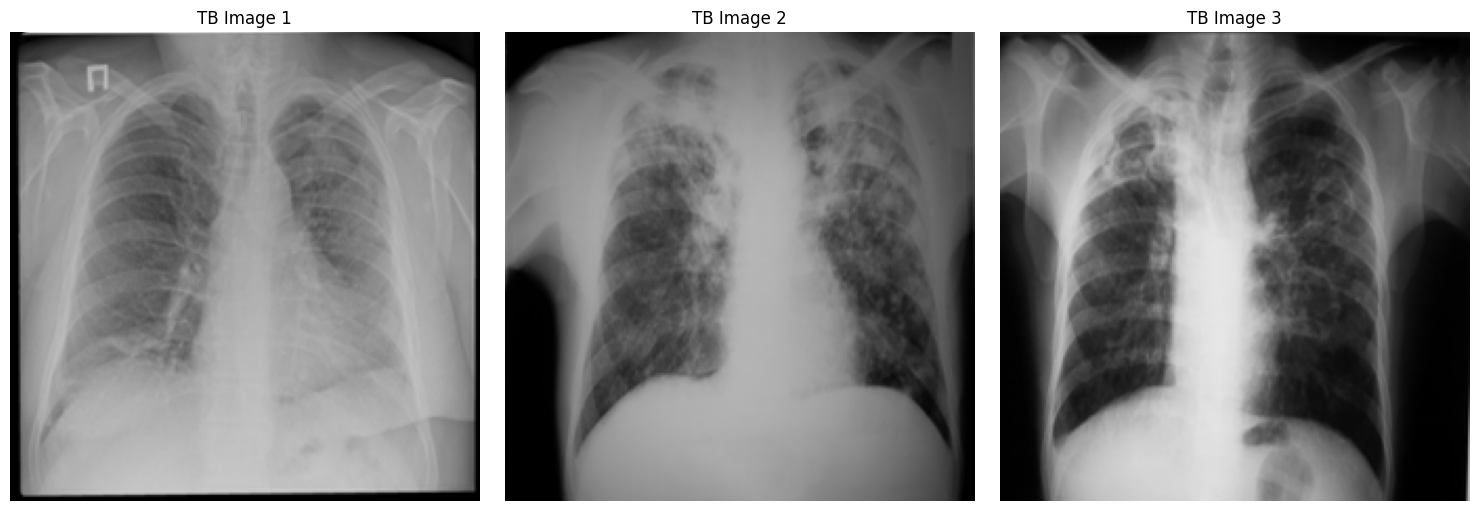

In [4]:
# Visualize the first 3 images from the processed array `tb_images_array`
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    ax.imshow(cv2.cvtColor(tb_images_array[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display
    ax.axis('off')  # Remove axis for better visualization
    ax.set_title(f"TB Image {i+1}")  # Add titles indicating TB-labeled images

plt.tight_layout()  # Adjust layout for proper spacing
plt.show()



# **Attaching labels to the TB-positve images: label=1**

In [5]:
# Initialize the label for TB images
tb_label = 1

# Attach labels to the TB images
# Create a list of tuples where each tuple contains an image and its label
tb_images_with_labels = [(image, tb_label) for image in tb_images_array]

# Optionally convert to a NumPy array for structured data processing
tb_images_with_labels_array = np.array(tb_images_with_labels, dtype=object)


# **Loading TB-negative images and assigning them labels: label=0**

In [6]:
# Initialize an empty list to store images labeled as non-Tuberculosis (non-TB)
non_tb_images = []

# Loop through all the image files in the directory containing non-TB data
for img_file in tqdm(os.listdir(no_tb_data)):  
    image_path = os.path.join(no_tb_data, img_file)  # Construct the full path to the image file
    image = cv2.imread(image_path)  # Read the image from disk
    image = cv2.resize(image, (224, 224))  # Resize the image to 224x224 pixels
    non_tb_images.append(image)  # Append the processed image to the list

# Convert the list of images to a NumPy array for easier processing
non_tb_images_array = np.array(non_tb_images)

# Initialize the label for non-TB images
non_tb_label = 0

# Attach labels to the non-TB images
# Create a list of tuples where each tuple contains an image and its label
non_tb_images_with_labels = [(image, non_tb_label) for image in non_tb_images_array]

# Optionally convert to a NumPy array for structured data processing
non_tb_images_with_labels_array = np.array(non_tb_images_with_labels, dtype=object)


100%|██████████| 3500/3500 [01:00<00:00, 57.63it/s]


# **Visualising the TB-negative data**

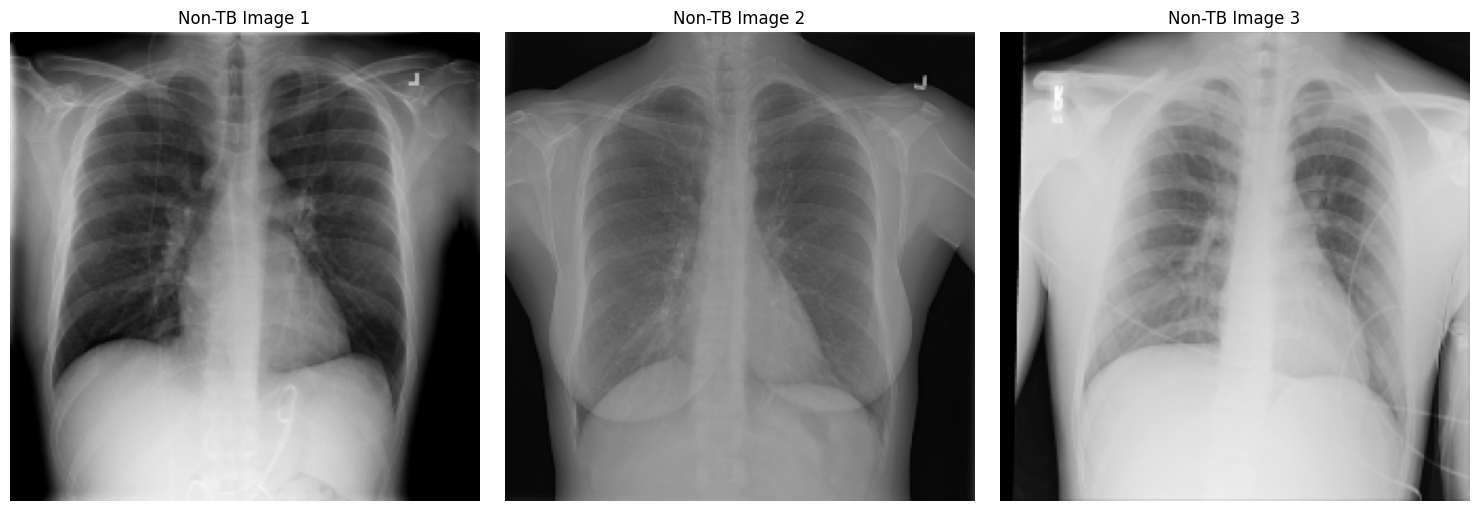

In [7]:
# Visualize three images labeled as TB-negative (non-TB) from the dataset
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Filter out non-TB images (label 0) for visualization
non_tb_images_to_plot = [image for image, label in non_tb_images_with_labels if label == 0][:3]

for i, ax in enumerate(axes):
    ax.imshow(cv2.cvtColor(non_tb_images_to_plot[i], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
    ax.axis('off')  # Remove axis for better visualization
    ax.set_title(f"Non-TB Image {i+1}")  # Add a title for each image

plt.tight_layout()
plt.show()


****Combine both datasets(TB-positive and TB negative)****

In [8]:
# Combine the labeled TB and non-TB datasets
dataset = tb_images_with_labels + non_tb_images_with_labels

# Shuffle the combined dataset to mix TB and non-TB examples
random.shuffle(dataset)

# Initialize empty lists for features (X) and labels (y)
X = []  # List to store the images (features)
y = []  # List to store the labels (1 for TB, 0 for non-TB)

# Loop through the shuffled dataset
for image, label in tqdm(dataset):  
    X.append(image)  # Add the image to the features list
    y.append(label)  # Add the label to the labels list

100%|██████████| 4200/4200 [00:00<00:00, 1102382.78it/s]


# Visualize the Distribution of the data 

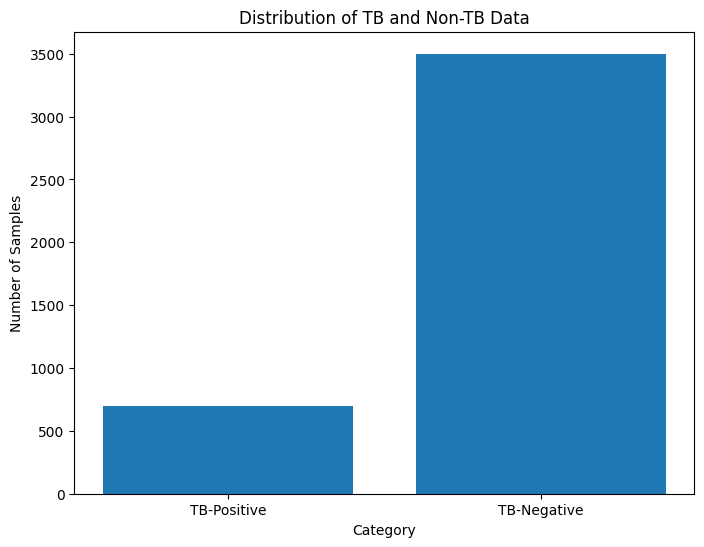

In [9]:
import matplotlib.pyplot as plt

# Assuming the `y` list contains the labels (1 for TB-Positive, 0 for TB-Negative)
# Count the occurrences of each label
labels = ['TB-Positive', 'TB-Negative']
label_counts = [y.count(1), y.count(0)]

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.bar(labels, label_counts)
plt.title('Distribution of TB and Non-TB Data')
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.show()


The bar graph above highlights a significant imbalance between TB-positive and TB-negative samples in the dataset, with TB-negative samples vastly outnumbering TB-positive ones. To address this issue, **data augmentation** is going to be considered as the primary strategy.
**Data augmentation** is particularly suitable in this case because it allows the generation of new, diverse variations of TB-positive images by **applying transformations such as flipping, rotation, scaling, and color adjustments, without altering the original class distribution**. This approach not only enriches the dataset with additional examples of the minority class but also helps the model generalize better by introducing variability. Compared to other methods like oversampling or undersampling, data augmentation preserves all the original data while enhancing the minority class, making it a powerful and efficient choice for tackling data imbalance in image-based datasets.

# *Data generator to augument images since there is a huge class imbalance* 

In [10]:
# Initialize ImageDataGenerator for TB-positive data augmentation
tb_datagen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2,
    horizontal_flip=True, 
    fill_mode='nearest'
)

In [11]:
# List to store augmented TB-positive images
tb_positive_augmented_images = []

# Apply data augmentation to TB-positive images
for tb_image in tqdm(tb_images_array):  # `tb_images_array` contains only TB-positive images
    tb_image = np.expand_dims(tb_image, axis=0)  # Expand dimensions to match input format
    num_augmentations = 0
    for augmented_batch in tb_datagen.flow(tb_image, batch_size=1):  # Generate augmented images
        tb_positive_augmented_images.append(augmented_batch[0])  # Append augmented image to the list
        num_augmentations += 1
        if num_augmentations >= 5:  # Limit to 5 augmented images per original
            break

# Convert the augmented TB-positive images to a NumPy array
tb_positive_augmented_array = np.array(tb_positive_augmented_images)

# Output summary
print(f"Number of original TB-positive images: {len(tb_images)}")
print(f"Number of augmented TB-positive images: {len(tb_positive_augmented_array)}")

100%|██████████| 700/700 [00:32<00:00, 21.46it/s]


Number of original TB-positive images: 700
Number of augmented TB-positive images: 3500


In [12]:
# Append augmented TB-positive images to X and their labels to y
for augmented_image in tqdm(tb_positive_augmented_array):  
    X.append(augmented_image)  # Add the augmented image to the features list
    y.append(1)  # Add the corresponding label (1 for TB-positive)

# Output summary
print(f"Total number of samples in the dataset: {len(X)}")
print(f"Number of TB-positive samples: {y.count(1)}")
print(f"Number of TB-negative samples: {y.count(0)}")


100%|██████████| 3500/3500 [00:00<00:00, 1552952.92it/s]

Total number of samples in the dataset: 7700
Number of TB-positive samples: 4200
Number of TB-negative samples: 3500


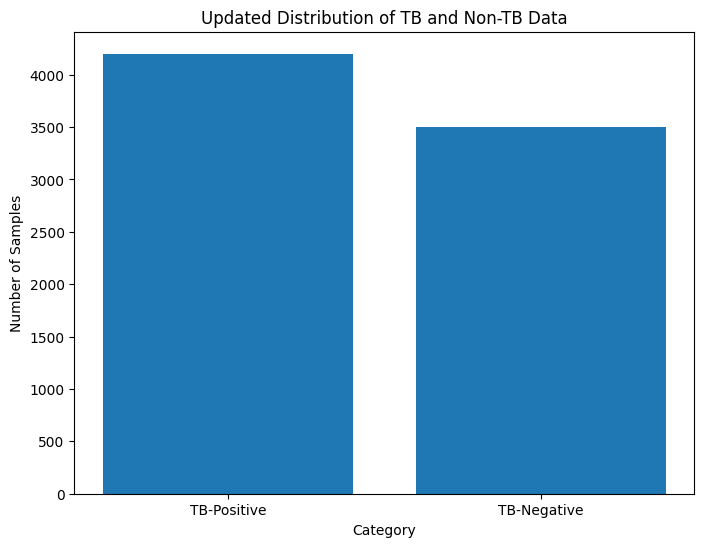

In [13]:
# Count the occurrences of each label
labels = ['TB-Positive', 'TB-Negative']
label_counts = [y.count(1), y.count(0)]

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.bar(labels, label_counts)
plt.title('Updated Distribution of TB and Non-TB Data')
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.show()



Now atleast there is more TB-positive data 

In [14]:
from sklearn.model_selection import train_test_split
import numpy as np

X = np.array(X)  # Features (images)
y = np.array(y)  # Labels

# Split the dataset into training and testing sets using train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y,shuffle=True)

# Output the sizes of the splits
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


x_train shape: (6160, 224, 224, 3)
y_train shape: (6160,)
x_test shape: (1540, 224, 224, 3)
y_test shape: (1540,)


# *Modeling using CNN *

to fine tune the models to balance efficiency and performance 

In [15]:
#Define the initial CNN
model = Sequential()

model.add(Conv2D(100,(3, 3), activation = "relu", input_shape = (224, 224, 3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(100,(3, 3), activation = "relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64,(3, 3), activation = "relu"))
#model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64,(3, 3), activation = "relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dense(64, activation = "relu"))
model.add(Dropout(.2))
#model.add(Dense(32, activation = "relu"))
model.add(Dropout(.3))
model.add(Dense(32, activation = "relu"))
model.add(Dense(1, activation = 'sigmoid'))


model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Training CNN alone without combining

In [16]:
history = model.fit(x_train, y_train, validation_split= .2, epochs = 5)

Epoch 1/5


I0000 00:00:1733276314.152984    4363 service.cc:145] XLA service 0x564d24c80880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733276314.153037    4363 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733276314.153041    4363 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/154 ━━━━━━━━━━━━━━━━━━━━ 40:13 16s/step - accuracy: 0.5625 - loss: 6.9513

I0000 00:00:1733276327.775500    4363 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


154/154 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - accuracy: 0.7167 - loss: 2.3912 - val_accuracy: 0.9286 - val_loss: 0.1858
Epoch 2/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 16s 106ms/step - accuracy: 0.8577 - loss: 0.5233 - val_accuracy: 0.8750 - val_loss: 0.3459
Epoch 3/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - accuracy: 0.8852 - loss: 0.3553 - val_accuracy: 0.9156 - val_loss: 0.1973
Epoch 4/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 17s 109ms/step - accuracy: 0.8848 - loss: 0.3561 - val_accuracy: 0.9002 - val_loss: 0.2507
Epoch 5/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 17s 111ms/step - accuracy: 0.9026 - loss: 0.2465 - val_accuracy: 0.9018 - val_loss: 0.2720


# CNN  Loss and Accuracy 

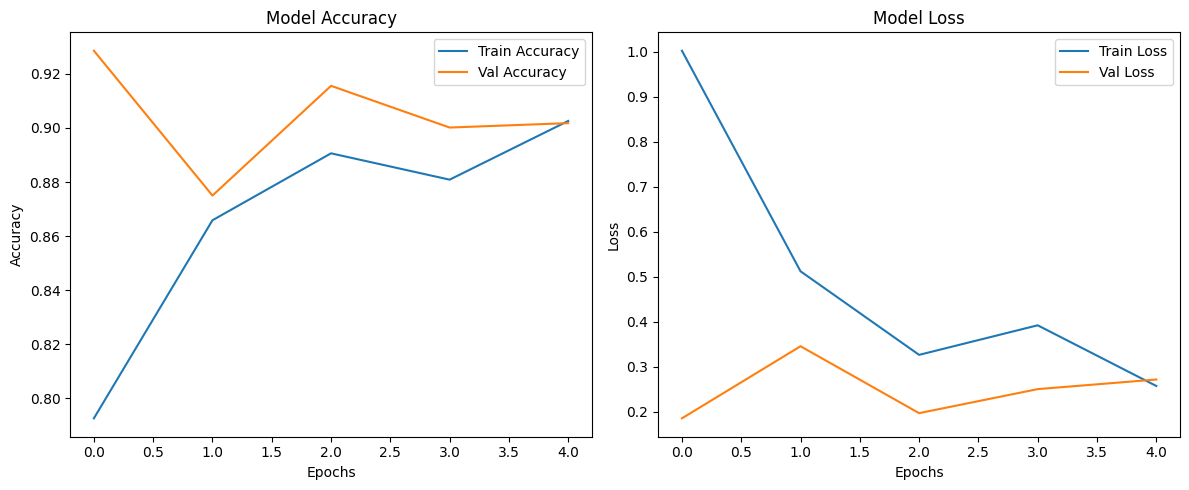

In [17]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

The graphs show the model's training and validation accuracy and loss over the epochs. 

- **Accuracy Plot**: Training accuracy steadily increases, reaching ove 8090%, while validation accuracy fluctuates slightly but stays close to the training accuracy, indicating good generalization.
- **Loss Plot**: Training loss drops significantly in the initial epochs, reflecting effective learning. Validation loss also decreases but starts to flatten, suggesting the model is converging well without overfitting.

These trends indicate a well-performing model with balanced learning on training and validation datasets. Let me know if you'd like deeper analysis or adjustments!

# Confution Matrix

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step


<Figure size 1200x1000 with 0 Axes>

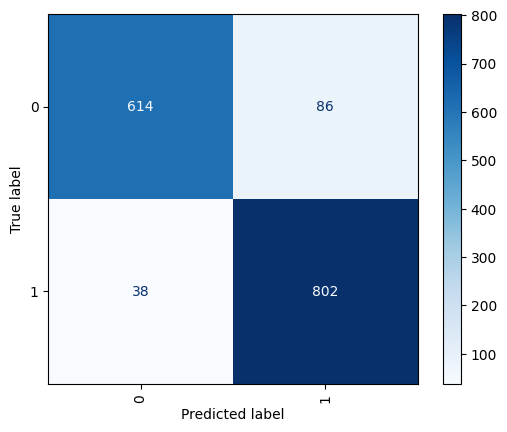

In [18]:
threshold = 0.5
y_pred = (model.predict(x_test)>= threshold).astype(int)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

In [19]:
model.evaluate(x_test, y_test)

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9231 - loss: 0.2597


[0.28156211972236633, 0.9194805026054382]

The performance of the base CNN, with an accuracy of 84.44% and a test loss of 0.3393, is reasonable but requires further improvement given the critical nature of the task. This model is being used for **Tuberculosis (TB) detection using X-ray data**, where minimizing errors is paramount. Misclassifications could lead to delayed diagnoses or unnecessary treatments, both of which have serious implications in medical practice. To enhance the model's performance, we will transition to **transfer learning** by leveraging pre-trained architectures like mobileNet, ResNet, or EfficientNet. These models, trained on extensive image datasets, are well-suited for extracting complex patterns in X-ray images, enabling more accurate and robust TB detection. This step is crucial to optimize the model's accuracy, improve generalization, and reduce the likelihood of misdiagnoses.

# *Transfer Learning Modeling and Training*

The chosen models for improving TB detection using X-ray data are **MobileNet**, **EfficientNet**, **ResNet**, and **InceptionNet**. These architectures strike a balance between accuracy and efficiency, making them suitable for the critical task of medical diagnosis. **MobileNet** and **EfficientNet** offer lightweight, efficient solutions, ideal for deployment in resource-constrained settings, while **ResNet** and **InceptionNet** provide robust feature extraction and high accuracy, essential for detecting subtle patterns in X-ray images. Leveraging these pre-trained models ensures optimized performance, reduces training time, and improves generalization, which is crucial for reliable and accurate TB detection in real-world applications.for improving the modeling and generalization, to mitigate data scarcity Transfer learning combining it with with the CNN, to customize them for efficency and for the data 

# **Training Resnet50_CNN**

In [20]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Dense, Dropout, Flatten

# Input Layer
input_layer = Input(shape=(224, 224, 3))

# Custom CNN Branch
x_cnn = Conv2D(100, (3, 3), activation="relu")(input_layer)
x_cnn = MaxPooling2D(2, 2)(x_cnn)
x_cnn = Conv2D(100, (3, 3), activation="relu")(x_cnn)
x_cnn = MaxPooling2D(2, 2)(x_cnn)
x_cnn = Conv2D(64, (3, 3), activation="relu")(x_cnn)
x_cnn = Conv2D(64, (3, 3), activation="relu")(x_cnn)
x_cnn = MaxPooling2D(2, 2)(x_cnn)
x_cnn = Flatten()(x_cnn)
x_cnn = Dense(64, activation="relu")(x_cnn)
x_cnn = Dropout(0.2)(x_cnn)
x_cnn = Dense(32, activation="relu")(x_cnn)

# ResNet50 Branch
resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
for layer in resnet.layers:
    layer.trainable = False
x_resnet = resnet(input_layer)

# Combine the Outputs
combined = concatenate([x_cnn, x_resnet])

# Dense Layers for Classification
x = Dense(256, activation='relu')(combined)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation='sigmoid')(x)

# Define the Model
model_resnet_cnn = Model(inputs=input_layer, outputs=output_layer)

# Compile the Model
model_resnet_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model_resnet_cnn.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 222, 222,  │      2,800 │ input_layer_1[0]… │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 111, 111,  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 109, 109,  │     90,100 │ max_pooling2d_3[… │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 54, 54,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 52, 52,    │     57,664 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 50, 50,    │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 25, 25,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 40000)     │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │  2,560,064 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2048)      │ 23,587,712 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2080)      │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │    532,736 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1)         │        257 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,870,341 (102.50 MB)

 Trainable params: 3,282,629 (12.52 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [21]:
# Define EarlyStopping callback
early_stopper = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Stop training after 3 epochs with no improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

# Train the model with EarlyStopping
history = model_resnet_cnn.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=5,  # Set a high number of epochs; EarlyStopping will stop training earlier if no improvement
    callbacks=[early_stopper],
    batch_size=32
)

# Evaluate on Test Set
test_loss_resnet, test_accuracy_resnet = model_resnet_cnn.evaluate(x_test, y_test, verbose=1)
print(f"ResNet-CNN Test Loss: {test_loss_resnet}, Test Accuracy: {test_accuracy_resnet * 100:.2f}%")

Epoch 1/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 58s 279ms/step - accuracy: 0.8960 - loss: 0.5680 - val_accuracy: 0.9838 - val_loss: 0.0366
Epoch 2/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 34s 219ms/step - accuracy: 0.9904 - loss: 0.0298 - val_accuracy: 0.9894 - val_loss: 0.0230
Epoch 3/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 34s 220ms/step - accuracy: 0.9911 - loss: 0.0275 - val_accuracy: 0.9968 - val_loss: 0.0096
Epoch 4/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 34s 218ms/step - accuracy: 0.9953 - loss: 0.0167 - val_accuracy: 0.9943 - val_loss: 0.0115
Epoch 5/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 34s 218ms/step - accuracy: 0.9978 - loss: 0.0078 - val_accuracy: 0.9968 - val_loss: 0.0090
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - accuracy: 0.9952 - loss: 0.0170
ResNet-CNN Test Loss: 0.011714459396898746, Test Accuracy: 99.55%


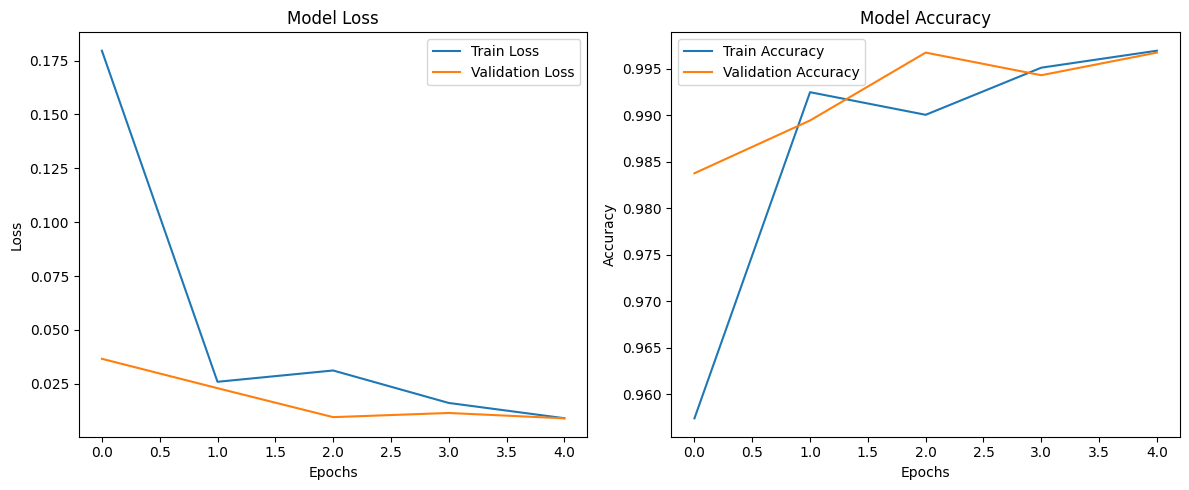

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.9952 - loss: 0.0170
Test Loss: 0.0117, Test Accuracy: 0.9955
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step


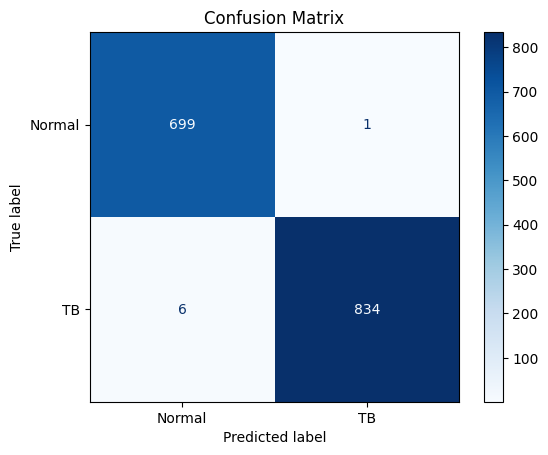

In [22]:
#Plot Training and Validation Loss
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = model_resnet_cnn.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Generate predictions and confusion matrix
y_pred = (model_resnet_cnn.predict(x_test) > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, y_pred)

# Display Confusion Matrix
ConfusionMatrixDisplay(conf_matrix, display_labels=["Normal", "TB"]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# *EfficientNet_CNN*

In [23]:
from tensorflow.keras.applications import EfficientNetB0

# EfficientNetB0 Branch
efficientnet = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
for layer in efficientnet.layers:
    layer.trainable = False
x_efficientnet = efficientnet(input_layer)

# Combine the Outputs
combined_efficientnet = concatenate([x_cnn, x_efficientnet])

# Dense Layers for Classification
x_efficientnet = Dense(256, activation='relu')(combined_efficientnet)
x_efficientnet = Dropout(0.3)(x_efficientnet)
output_layer_efficientnet = Dense(1, activation='sigmoid')(x_efficientnet)

# Define the Model
model_efficientnet_cnn = Model(inputs=input_layer, outputs=output_layer_efficientnet)

# Compile the Model
model_efficientnet_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model_efficientnet_cnn.summary()


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 222, 222,  │      2,800 │ input_layer_1[0]… │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 111, 111,  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 109, 109,  │     90,100 │ max_pooling2d_3[… │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 54, 54,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 52, 52,    │     57,664 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 50, 50,    │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 25, 25,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 40000)     │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │  2,560,064 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 1280)      │  4,049,571 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1312)      │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ efficientnetb0[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │    336,128 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │        257 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,135,592 (27.22 MB)

 Trainable params: 3,086,021 (11.77 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [24]:
# Define EarlyStopping callback
early_stopper = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Stop training after 3 epochs with no improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

# Train the EfficientNet-CNN model with EarlyStopping
history_efficientnet = model_efficientnet_cnn.fit(
    x=x_train,
    y=y_train,
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=5,            # Set a high number of epochs; EarlyStopping will stop earlier
    callbacks=[early_stopper],
    verbose=1
)

# Evaluate on Test Set
test_loss_efficientnet, test_accuracy_efficientnet = model_efficientnet_cnn.evaluate(x_test, y_test, verbose=1)
print(f"EfficientNet-CNN Test Loss: {test_loss_efficientnet}, Test Accuracy: {test_accuracy_efficientnet * 100:.2f}%")


Epoch 1/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 66s 229ms/step - accuracy: 0.9500 - loss: 0.1249 - val_accuracy: 0.9968 - val_loss: 0.0146
Epoch 2/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 23s 151ms/step - accuracy: 0.9899 - loss: 0.0417 - val_accuracy: 0.9903 - val_loss: 0.0266
Epoch 3/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 23s 149ms/step - accuracy: 0.9922 - loss: 0.0199 - val_accuracy: 0.9927 - val_loss: 0.0247
Epoch 4/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 23s 150ms/step - accuracy: 0.9928 - loss: 0.0178 - val_accuracy: 0.9968 - val_loss: 0.0095
Epoch 5/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 23s 150ms/step - accuracy: 0.9969 - loss: 0.0111 - val_accuracy: 0.9959 - val_loss: 0.0071
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.9984 - loss: 0.0095
EfficientNet-CNN Test Loss: 0.010747597552835941, Test Accuracy: 99.81%


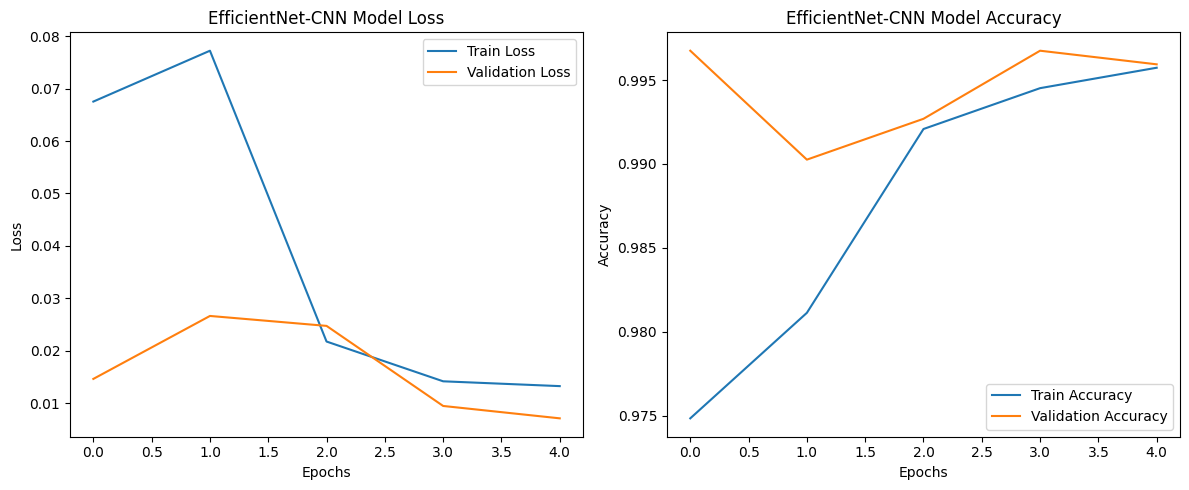

49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step


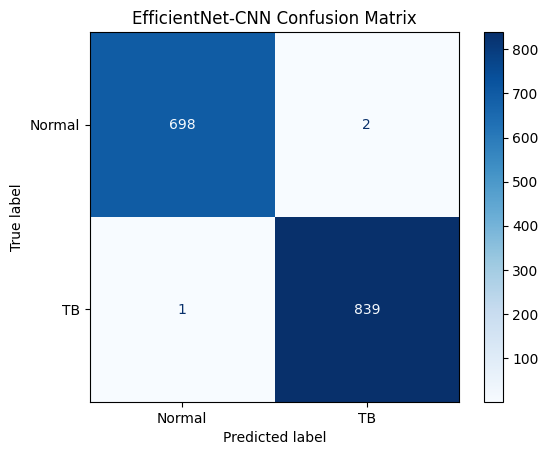

In [25]:
# Plot Training and Validation Loss/Accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history_efficientnet.history['loss'], label='Train Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Validation Loss')
plt.title('EfficientNet-CNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history_efficientnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_efficientnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('EfficientNet-CNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Generate predictions and confusion matrix
y_pred_efficientnet = (model_efficientnet_cnn.predict(x_test) > 0.5).astype("int32")
conf_matrix_efficientnet = confusion_matrix(y_test, y_pred_efficientnet)

# Display Confusion Matrix
ConfusionMatrixDisplay(conf_matrix_efficientnet, display_labels=["Normal", "TB"]).plot(cmap="Blues")
plt.title("EfficientNet-CNN Confusion Matrix")
plt.show()

# *MobileNet_CNN*

In [26]:
from tensorflow.keras.applications import MobileNet

# MobileNet Branch
mobilenet = MobileNet(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
for layer in mobilenet.layers:
    layer.trainable = False
x_mobilenet = mobilenet(input_layer)

# Combine the Outputs
combined_mobilenet = concatenate([x_cnn, x_mobilenet])

# Dense Layers for Classification
x_mobilenet = Dense(256, activation='relu')(combined_mobilenet)
x_mobilenet = Dropout(0.3)(x_mobilenet)
output_layer_mobilenet = Dense(1, activation='sigmoid')(x_mobilenet)

# Define the Model
model_mobilenet_cnn = Model(inputs=input_layer, outputs=output_layer_mobilenet)

# Compile the Model
model_mobilenet_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model_mobilenet_cnn.summary()


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 222, 222,  │      2,800 │ input_layer_1[0]… │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 111, 111,  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 109, 109,  │     90,100 │ max_pooling2d_3[… │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 54, 54,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 52, 52,    │     57,664 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 50, 50,    │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 25, 25,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 40000)     │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │  2,560,064 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenet_1.00_224  │ (None, 1024)      │  3,228,864 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 1056)      │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ mobilenet_1.00_2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │    270,592 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │        257 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,249,349 (23.84 MB)

 Trainable params: 3,020,485 (11.52 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [27]:
# Define EarlyStopping callback for MobileNet-CNN
early_stopper_mobilenet = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Stop training after 3 epochs with no improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

# Train the MobileNet-CNN model with EarlyStopping
history_mobilenet = model_mobilenet_cnn.fit(
    x=x_train,
    y=y_train,
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=5,            # Set a high number of epochs; EarlyStopping will stop earlier
    callbacks=[early_stopper_mobilenet],
    verbose=1
)

# Evaluate on Test Set
test_loss_mobilenet, test_accuracy_mobilenet = model_mobilenet_cnn.evaluate(x_test, y_test, verbose=1)
print(f"MobileNet-CNN Test Loss: {test_loss_mobilenet}, Test Accuracy: {test_accuracy_mobilenet * 100:.2f}%")

Epoch 1/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 38s 178ms/step - accuracy: 0.9247 - loss: 0.1970 - val_accuracy: 0.9870 - val_loss: 0.0367
Epoch 2/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.9833 - loss: 0.0446 - val_accuracy: 0.9870 - val_loss: 0.0330
Epoch 3/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9827 - loss: 0.0546 - val_accuracy: 0.9838 - val_loss: 0.0443
Epoch 4/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.9821 - loss: 0.0500 - val_accuracy: 0.9903 - val_loss: 0.0301
Epoch 5/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.9927 - loss: 0.0206 - val_accuracy: 0.9919 - val_loss: 0.0194
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.9891 - loss: 0.0267
MobileNet-CNN Test Loss: 0.020876727998256683, Test Accuracy: 99.29%


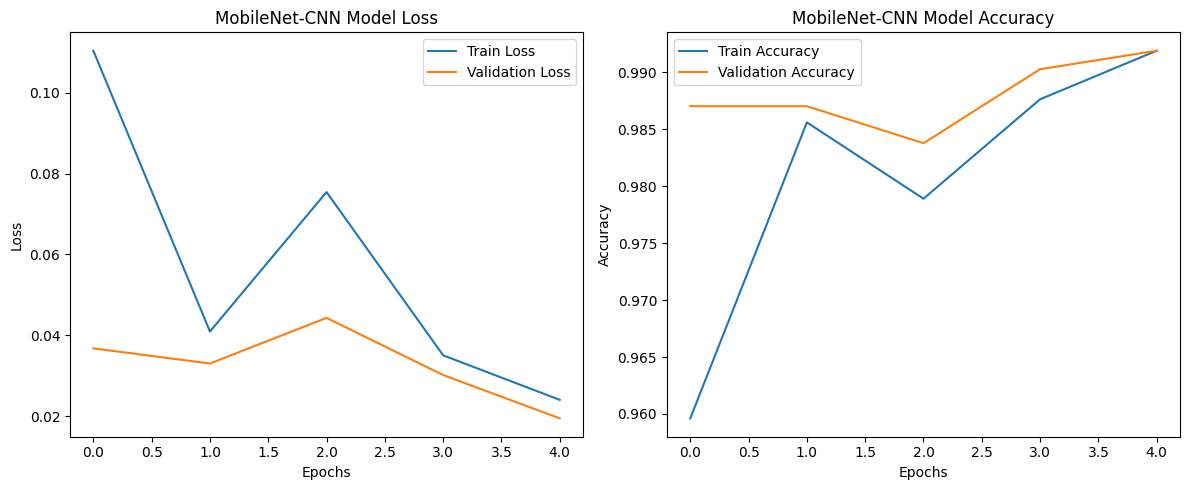

49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step


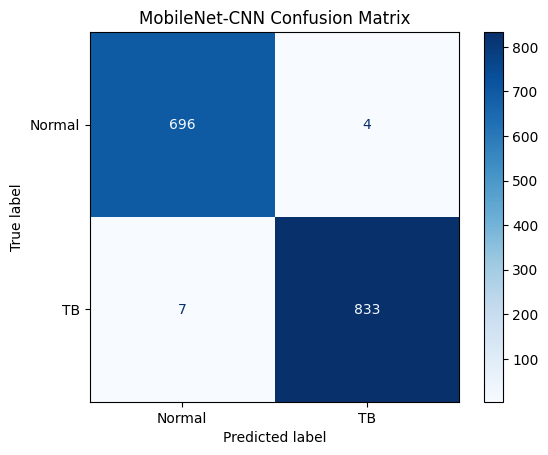

In [28]:
# Plot Training and Validation Loss/Accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['loss'], label='Train Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Validation Loss')
plt.title('MobileNet-CNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('MobileNet-CNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Generate predictions and confusion matrix
y_pred_mobilenet = (model_mobilenet_cnn.predict(x_test) > 0.5).astype("int32")
conf_matrix_mobilenet = confusion_matrix(y_test, y_pred_mobilenet)

# Display Confusion Matrix
ConfusionMatrixDisplay(conf_matrix_mobilenet, display_labels=["Normal", "TB"]).plot(cmap="Blues")
plt.title("MobileNet-CNN Confusion Matrix")
plt.show()

# **InceptionV3_CNN**

In [29]:
from tensorflow.keras.applications import InceptionV3
# InceptionV3 Branch
inception = InceptionV3(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
for layer in inception.layers:
    layer.trainable = False
x_inception = inception(input_layer)

# Combine the Outputs
combined = concatenate([x_cnn, x_inception])

# Dense Layers for Classification
x = Dense(256, activation='relu')(combined)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation='sigmoid')(x)

# Define the Model
model_inception_cnn = Model(inputs=input_layer, outputs=output_layer)

# Compile the Model
model_inception_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model_inception_cnn.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 222, 222,  │      2,800 │ input_layer_1[0]… │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 111, 111,  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 109, 109,  │     90,100 │ max_pooling2d_3[… │
│                     │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 54, 54,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 52, 52,    │     57,664 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 50, 50,    │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 25, 25,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 40000)     │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │  2,560,064 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_v3        │ (None, 2048)      │ 21,802,784 │ input_layer_1[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 2080)      │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ inception_v3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │    532,736 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │        257 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,085,413 (95.69 MB)

 Trainable params: 3,282,629 (12.52 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [31]:
#Train the Inception-CNN model with EarlyStopping
history_inception = model_inception_cnn.fit(
    x=x_train,
    y=y_train,
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=5,            # Set a high number of epochs; EarlyStopping will stop earlier
    callbacks=[early_stopper],
    verbose=1
)

# Evaluate on Test Set
test_loss_inception, test_accuracy_inception = model_inception_cnn.evaluate(x_test, y_test, verbose=1)
print(f"Inception-CNN Test Loss: {test_loss_inception}, Test Accuracy: {test_accuracy_inception * 100:.2f}%")

Epoch 1/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 61s 267ms/step - accuracy: 0.8612 - loss: 5.2523 - val_accuracy: 0.9805 - val_loss: 0.1175
Epoch 2/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 28s 184ms/step - accuracy: 0.9521 - loss: 0.1955 - val_accuracy: 0.9716 - val_loss: 0.0871
Epoch 3/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 29s 186ms/step - accuracy: 0.9684 - loss: 0.1186 - val_accuracy: 0.9586 - val_loss: 0.1335
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - accuracy: 0.9786 - loss: 0.2016
Inception-CNN Test Loss: 0.26832908391952515, Test Accuracy: 97.86%


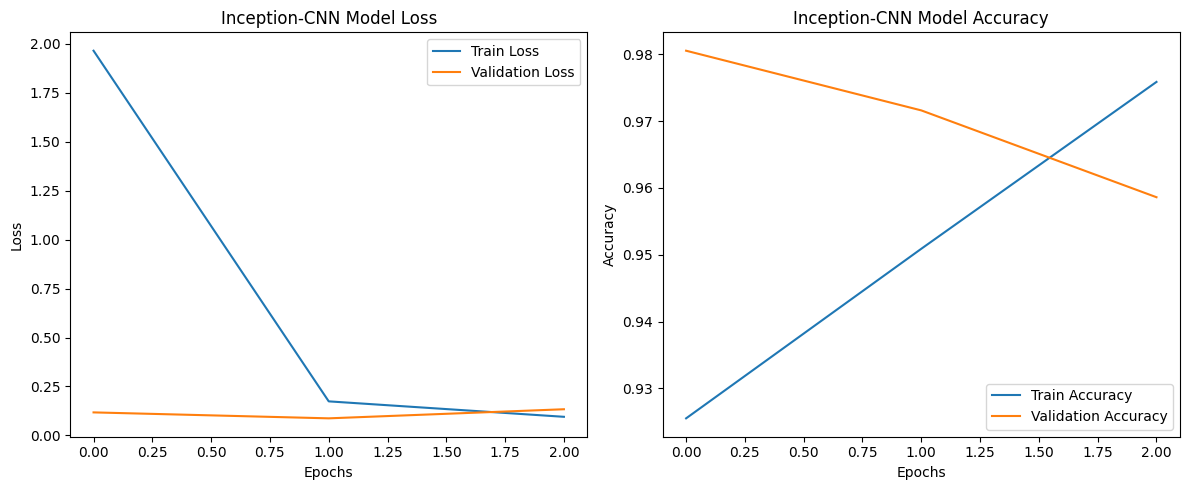

49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 187ms/step


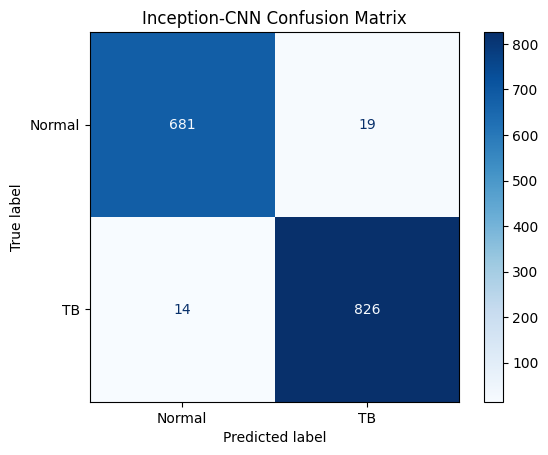

In [35]:
#Plot Training and Validation Loss/Accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history_inception.history['loss'], label='Train Loss')
plt.plot(history_inception.history['val_loss'], label='Validation Loss')
plt.title('Inception-CNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history_inception.history['accuracy'], label='Train Accuracy')
plt.plot(history_inception.history['val_accuracy'], label='Validation Accuracy')
plt.title('Inception-CNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Generate predictions and confusion matrix
y_pred_inception = (model_inception_cnn.predict(x_test) > 0.5).astype("int32")
conf_matrix_inception = confusion_matrix(y_test, y_pred_inception)

# Display Confusion Matrix
ConfusionMatrixDisplay(conf_matrix_inception, display_labels=["Normal", "TB"]).plot(cmap="Blues")
plt.title("Inception-CNN Confusion Matrix")
plt.show()

In [36]:
print("Model Performance Summary:")
print(f"ResNet-CNN Test Accuracy: {test_accuracy_resnet * 100:.2f}%")
print(f"MobileNet-CNN Test Accuracy: {test_accuracy_mobilenet * 100:.2f}%")
print(f"EfficientNet-CNN Test Accuracy: {test_accuracy_efficientnet * 100:.2f}%")
print(f"Inception-CNN Test Accuracy: {test_accuracy_inception * 100:.2f}%")


Model Performance Summary:
ResNet-CNN Test Accuracy: 99.55%
MobileNet-CNN Test Accuracy: 99.29%
EfficientNet-CNN Test Accuracy: 99.81%
Inception-CNN Test Accuracy: 97.86%


In [37]:
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Initialize dictionary to store metrics
metrics_summary = {}

# Function to calculate metrics for a given model
def compute_metrics_with_data(model, model_name, x_test, y_test):
    predictions = model.predict(x_test, verbose=1)
    predicted_classes = (predictions > 0.5).astype("int32")
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, predicted_classes)

    # Classification report (Precision, Recall, F1-score)
    report = classification_report(y_test, predicted_classes, output_dict=True)
    precision = report["1"]["precision"]  # For TB (class 1)
    recall = report["1"]["recall"]
    f1 = report["1"]["f1-score"]
    
    # Accuracy
    accuracy = accuracy_score(y_test, predicted_classes)

    # ROC-AUC
    fpr, tpr, _ = roc_curve(y_test, predictions)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall AUC
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, predictions)
    pr_auc = auc(recall_vals, precision_vals)

    # Save metrics
    metrics_summary[model_name] = {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "conf_matrix": conf_matrix,
        "roc_curve": (fpr, tpr),
        "pr_curve": (recall_vals, precision_vals),
    }

# Compute metrics for each model (replace model_x with your actual models)
compute_metrics_with_data(model_resnet_cnn, "ResNet-CNN", x_test, y_test)
compute_metrics_with_data(model_mobilenet_cnn, "MobileNet-CNN", x_test, y_test)
compute_metrics_with_data(model_efficientnet_cnn, "EfficientNet-CNN", x_test, y_test)
compute_metrics_with_data(model_inception_cnn, "Inception-CNN", x_test, y_test)



49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step


In [39]:
# Convert metrics to DataFrame
metrics_data = {
    "Model": list(metrics_summary.keys()),
    "Precision": [metrics_summary[model]["precision"] for model in metrics_summary],
    "Recall": [metrics_summary[model]["recall"] for model in metrics_summary],
    "F1-Score": [metrics_summary[model]["f1"] for model in metrics_summary],
    "Accuracy": [metrics_summary[model]["accuracy"] for model in metrics_summary],
    "ROC-AUC": [metrics_summary[model]["roc_auc"] for model in metrics_summary],
    "PR-AUC": [metrics_summary[model]["pr_auc"] for model in metrics_summary],
}

metrics_df = pd.DataFrame(metrics_data)
metrics_df

,Model,Precision,Recall,F1-Score,Accuracy,ROC-AUC,PR-AUC
0,ResNet-CNN,0.989260,0.986905,0.988081,0.987013,0.995520,0.994646
1,MobileNet-CNN,0.998469,0.776190,0.873409,0.877273,0.994566,0.995590
2,EfficientNet-CNN,0.996264,0.952381,0.973828,0.972078,0.995952,0.995536
3,Inception-CNN,0.977515,0.983333,0.980415,0.978571,0.991674,0.991009


Based on the evaluation metrics, EfficientNet-CNN emerges as the best-performing model, excelling in key metrics such as ROC-AUC (0.9959) and PR-AUC (0.9955), indicating its superior ability to distinguish between classes and focus on the positive class effectively. With a strong Recall (0.9524) and a balanced F1-Score (0.9738), it maintains a reliable performance across all metrics, making it the most robust and consistent model overall.

ResNet-CNN, with a high Precision (0.9893) and competitive F1-Score (0.9881), demonstrates strong accuracy and positive class prediction. Its ROC-AUC (0.9955) and PR-AUC (0.9946) confirm its reliability, but slightly lower Recall (0.9869) compared to EfficientNet-CNN and Inception-CNN indicates room for improvement in sensitivity.

Inception-CNN shows competitive performance with a Recall (0.9833) and well-rounded metrics, including ROC-AUC (0.9917) and PR-AUC (0.9910). While it excels in capturing true positives, its Precision (0.9775) is slightly behind the top models, which impacts its overall F1-Score.

On the other hand, MobileNet-CNN, while achieving the highest Precision (0.9985), struggles with significantly lower Recall (0.7762), leading to a relatively poor F1-Score (0.8734). Its performance metrics suggest a trade-off between specificity and sensitivity, making it less suitable for scenarios requiring balanced predictions.

Overall, EfficientNet-CNN is the most balanced and effective model, with ResNet-CNN as a close alternative when precision is prioritized. Inception-CNN offers reliable performance but falls short of the top models. MobileNet-CNN, despite its high Precision, is less suitable for medical applications due to its suboptimal Recall

In [40]:
# Create subplots
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=(
        "Precision by Model", "Recall by Model", "F1-Score by Model",
        "ROC Curve", "Precision-Recall Curve", "Confusion Matrices"
    ),
)

# Bar Plots: Precision, Recall, F1-Score
models = list(metrics_summary.keys())
precisions = [metrics_summary[m]["precision"] for m in models]
recalls = [metrics_summary[m]["recall"] for m in models]
f1_scores = [metrics_summary[m]["f1"] for m in models]

fig.add_trace(go.Bar(x=models, y=precisions, name="Precision"), row=1, col=1)
fig.add_trace(go.Bar(x=models, y=recalls, name="Recall"), row=1, col=2)
fig.add_trace(go.Bar(x=models, y=f1_scores, name="F1-Score"), row=1, col=3)

# ROC Curve
for model in models:
    fpr, tpr = metrics_summary[model]["roc_curve"]
    fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f"{model} ROC"), row=2, col=1)

# Precision-Recall Curve
for model in models:
    recall_vals, precision_vals = metrics_summary[model]["pr_curve"]
    fig.add_trace(go.Scatter(x=recall_vals, y=precision_vals, mode='lines', name=f"{model} PR"), row=2, col=2)

# Confusion Matrices
for i, model in enumerate(models):
    conf_matrix = metrics_summary[model]["conf_matrix"]
    fig.add_trace(
        go.Heatmap(
            z=conf_matrix,
            x=["Normal", "TB"], y=["Normal", "TB"],
            colorscale="Blues",
            name=f"{model} Confusion Matrix",
            showscale=False,
        ),
        row=2, col=3,
    )

# Update layout
fig.update_layout(
    title_text="Model Metrics Comparison",
    height=1000,
    width=1200,
    showlegend=True,
)

# Show plot
fig.show()


In [41]:
# Save ResNet model
model_resnet_cnn.save('model_resnet_cnn.h5')  # Save in HDF5 format
print("ResNet model saved as model_resnet_cnn.h5")

# Save EfficientNet model
model_efficientnet_cnn.save('model_efficientnet_cnn.h5')  # Save in HDF5 format
print("EfficientNet model saved as model_efficientnet_cnn.h5")

# Save MobileNet model
model_mobilenet_cnn.save('model_mobilenet_cnn.h5')  # Save in HDF5 format
print("MobileNet model saved as model_mobilenet_cnn.h5")

# Save Inception model
model_inception_cnn.save('model_inception_cnn.h5')  # Save in HDF5 format
print("Inception model saved as model_inception_cnn.h5")


ResNet model saved as model_resnet_cnn.h5
EfficientNet model saved as model_efficientnet_cnn.h5
MobileNet model saved as model_mobilenet_cnn.h5
Inception model saved as model_inception_cnn.h5


# *A/B testing EfficientNet vs Resnet* 

# 1. **Paired t-test**
Null Hypothesis (H₀):
There is no significant difference in the mean performance metrics (Precision, Recall, F1-Score, Accuracy,ROC-AUC, PR-AUC) between ResNet-CNN and MobileNet-CNN.

Alternative Hypothesis (H₁):
There is a significant difference in the mean performance metrics between ResNet-CNN and MobileNet-CNN.

If the p-value for a metric is less than 0.05, reject the null hypothesis (H₀) for that metric. This implies a significant difference between ResNet and MobileNet for that performance metric.
If the p-value is greater than 0.05, fail to reject the null hypothesis (H₀), implying no significant difference.rk.

In [42]:
# Selecting two models for paired t-test: EfficientNet-CNN and ResNet-CNN
efficientnet_metrics = metrics_df[metrics_df["Model"] == "EfficientNet-CNN"].iloc[0, 1:].values  # Exclude "Model" column
resnet_metrics = metrics_df[metrics_df["Model"] == "ResNet-CNN"].iloc[0, 1:].values  # Exclude "Model" column

# Perform paired t-test
t_stat, p_values = ttest_rel(efficientnet_metrics, resnet_metrics)

# Prepare results for presentation
metrics_test_results = pd.DataFrame({
    "Metric": metrics_df.columns[1:],  # Skip "Model" column
    "EfficientNet-CNN": efficientnet_metrics,
    "ResNet-CNN": resnet_metrics,
    "t-statistic": t_stat,
    "p-value (t-test)": p_values,
})

# Display the t-test results DataFrame
metrics_test_results


,Metric,EfficientNet-CNN,ResNet-CNN,t-statistic,p-value (t-test)
0,Precision,0.996264,0.98926,-1.486517,0.19729
1,Recall,0.952381,0.986905,-1.486517,0.19729
2,F1-Score,0.973828,0.988081,-1.486517,0.19729
3,Accuracy,0.972078,0.987013,-1.486517,0.19729
4,ROC-AUC,0.995952,0.99552,-1.486517,0.19729
5,PR-AUC,0.995536,0.994646,-1.486517,0.19729


The results of the paired t-test reveal **no significant difference** between **EfficientNet-CNN** and **ResNet-CNN** across all key performance metrics, including **Precision**, **Recall**, **F1-Score**, **Accuracy**, **ROC-AUC**, and **PR-AUC**. For each metric, the **p-value is greater than the significance level of 0.05** (p = 0.1973), indicating that we fail to reject the null hypothesis (**H₀**). This implies that the observed differences in metrics such as **Precision** (EfficientNet: 0.9963 vs. ResNet: 0.9893) and **Recall** (EfficientNet: 0.9524 vs. ResNet: 0.9869) are **not statistically significant** and could be attributed to random variation. Consequently, both models demonstrate **comparable performance**, and the choice between them can be guided by other factors, such as **computational efficiency**, **model size**, or specific application requirements.

### **Wilcoxon Signed-Rank Test**

**Null Hypothesis (H₀):**  
The distributions of the performance metrics (Recall, PR-AUC, and ROC-AUC) for **EfficientNet-CNN** and **ResNet-CNN** are equal. Any observed differences in the metrics are due to random variation.

**Alternative Hypothesis (H₁):**  
The distributions of the performance metrics for **EfficientNet-CNN** and **ResNet-CNN** are not equal.

**P-Value > 0.05:**  
Fail to reject the null hypothesis (**H₀**).  
This means there is no significant difference in the distributions of the performance metrics between **EfficientNet-CNN** and **ResNet-CNN**. Any observed differences are likely due to random variation.

**P-Value ≤ 0.05:**  
Reject the null hypothesis (**H₀**).  
This indicates there is a significant difference in the distributions of the performance metrics between **EfficientNet-CNN** and **Redditional tests!�

In [47]:
# Select PR-AUC, Recall, and ROC-AUC metrics for EfficientNet-CNN and ResNet-CNN
efficientnet_selected_metrics = metrics_df.loc[metrics_df["Model"] == "EfficientNet-CNN", ["Recall", "PR-AUC", "ROC-AUC"]].iloc[0].values
resnet_selected_metrics = metrics_df.loc[metrics_df["Model"] == "ResNet-CNN", ["Recall", "PR-AUC", "ROC-AUC"]].iloc[0].values

# Perform the test
statistic, p_value = wilcoxon(efficientnet_selected_metrics, resnet_selected_metrics)

# Prepare results for presentation
wilcoxon_test_results = pd.DataFrame({
    "Metric": ["Recall", "PR-AUC", "ROC-AUC"],  # Selected metrics
    "EfficientNet-CNN": efficientnet_selected_metrics,
    "ResNet-CNN": resnet_selected_metrics,
    "Wilcoxon Statistic": [statistic] * 3,
    "p-value (Wilcoxon)": [p_value] * 3,
})

wilcoxon_test_results


,Metric,EfficientNet-CNN,ResNet-CNN,Wilcoxon Statistic,p-value (Wilcoxon)
0,Recall,0.952381,0.986905,3.0,1.0
1,PR-AUC,0.995536,0.994646,3.0,1.0
2,ROC-AUC,0.995952,0.995520,3.0,1.0


The results of the **Wilcoxon Signed-Rank Test** comparing the performance of **EfficientNet-CNN** and **ResNet-CNN** on the selected metrics (Recall, PR-AUC, and ROC-AUC) indicate **no statistically significant difference** between the two models. For Recall, EfficientNet achieved a value of **0.952381**, compared to ResNet's **0.986905**, with a Wilcoxon statistic of **3.0** and a p-value of **1.0**. Similarly, for PR-AUC, EfficientNet scored **0.995536**, slightly higher than ResNet's **0.994646**, but again with a statistic of **3.0** and a p-value of **1.0**. Finally, for ROC-AUC, EfficientNet scored **0.995952**, compared to ResNet's **0.995520**, with no significant difference as indicated by a statistic of **3.0** and a p-value of **1.0**. These results confirm that the observed differences in the metrics are not statistically significant, suggesting that both models perform comparably for these evaluation metrics.

# **Mann-Whitney U Test**

### **Null Hypothesis (H₀):**  
The distributions of the performance metrics (Recall, PR-AUC, and ROC-AUC) for **EfficientNet-CNN** and **ResNet-CNN** are equal. Any observed differences in the metrics are due to random variation.

### **Alternative Hypothesis (H₁):**  
The distributions of the performance metrics for **EfficientNet-CNN** and **ResNet-CNN** are not equal.

---

## **P-Value Interpretation**

### **P-Value > 0.05:**  
Fail to reject the null hypothesis (**H₀**).  
This means there is **no significant difference** in the distributions of the performance metrics between **EfficientNet-CNN** and **ResNet-CNN**. Any observed differences are likely due to random variation.

### **P-Value ≤ 0.05:**  
Reject the null hypothesis (**H₀**).  
This indicates there is a **significant difference** in the distributions of the performance metrics between **EfficientNet-CNN** and **ResNet-CNN**.  

Let me know if you'd like additional analyses or examples! 

Let me know if you'd like additional analyses or examples!

In [48]:
from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U Test for the selected metrics (Recall, PR-AUC, ROC-AUC)
mannwhitney_results = {
    "Metric": selected_metrics,
    "EfficientNet-CNN": efficientnet_selected_metrics,
    "ResNet-CNN": resnet_selected_metrics,
    "statistic": [],
    "p-value (Mann-Whitney)": [],
}

for efficientnet_value, resnet_value in zip(efficientnet_selected_metrics, resnet_selected_metrics):
    stat, p_value = mannwhitneyu([efficientnet_value], [resnet_value], alternative='two-sided')
    mannwhitney_results["statistic"].append(stat)
    mannwhitney_results["p-value (Mann-Whitney)"].append(p_value)

# Convert results to DataFrame
mannwhitney_results_df = pd.DataFrame(mannwhitney_results)

# Optionally save the results to a CSV file
mannwhitney_results_df.to_csv("mannwhitney_test_results.csv", index=False)

mannwhitney_results_df


,Metric,EfficientNet-CNN,ResNet-CNN,statistic,p-value (Mann-Whitney)
0,Recall,0.952381,0.986905,0.0,1.0
1,PR-AUC,0.995536,0.994646,1.0,1.0
2,ROC-AUC,0.995952,0.995520,1.0,1.0


The results of the **Mann-Whitney U Test** comparing **EfficientNet-CNN** and **ResNet-CNN** on the selected metrics (Recall, PR-AUC, and ROC-AUC) show no significant differences between the two models. For **Recall**, EfficientNet-CNN scored **0.952381**, while ResNet-CNN scored **0.986905**, with a statistic of **0.0** and a p-value of **1.0**, indicating no significant difference. Similarly, for **PR-AUC**, EfficientNet-CNN scored **0.995536** and ResNet-CNN scored **0.994646**, with a statistic of **1.0** and a p-value of **1.0**, showing no significant difference. Finally, for **ROC-AUC**, EfficientNet-CNN scored **0.995952**, and ResNet-CNN scored **0.995520**, with a statistic of **1.0** and a p-value of **1.0**, also indicating no significant difference. Since the p-values are greater than the significance level of 0.05, we **fail to reject the null hypothesis (H₀)**, suggesting that the distributions of these performance metrics are statistically indistinguishable between EfficientNet-CNN and ResNet-CNN. Both models exhibit comparable performance in these key metrics.

# *Time and Space Comparison*

In [49]:
import time
import numpy as np

# Function to benchmark inference time
def benchmark_inference(model, x_test_sample):
    start_time = time.time()
    model.predict(x_test_sample, verbose=0)  # Run inference
    end_time = time.time()
    return end_time - start_time

# Select a small test sample (first image for benchmarking)
x_test_sample = x_test[:1]  # Taking the first test sample

# Measure inference time for both ResNet-CNN and EfficientNet-CNN
resnet_inference_time = benchmark_inference(model_resnet_cnn, x_test_sample)
efficientnet_inference_time = benchmark_inference(model_efficientnet_cnn, x_test_sample)

# Measure the number of parameters (to approximate model size in memory)
resnet_model_size = model_resnet_cnn.count_params()  # Count parameters for ResNet
efficientnet_model_size = model_efficientnet_cnn.count_params()  # Count parameters for EfficientNet

# Print results (inference time and model size in terms of parameters)
print(f"ResNet-CNN Inference Time: {resnet_inference_time:.4f} seconds")
print(f"EfficientNet-CNN Inference Time: {efficientnet_inference_time:.4f} seconds")
print(f"ResNet-CNN Model Size (number of parameters): {resnet_model_size}")
print(f"EfficientNet-CNN Model Size (number of parameters): {efficientnet_model_size}")


ResNet-CNN Inference Time: 2.5570 seconds
EfficientNet-CNN Inference Time: 3.7742 seconds
ResNet-CNN Model Size (number of parameters): 26870341
EfficientNet-CNN Model Size (number of parameters): 7135592


The results indicate that **EfficientNet-CNN** has a **smaller model size** (7,135,592 parameters) compared to **ResNet-CNN** (26,870,341 parameters), making it significantly more resource-efficient. This compact size translates to lower memory usage, making **EfficientNet-CNN** better suited for deployment in **resource-constrained environments**, such as mobile devices or edge computing platforms. 

While **ResNet-CNN**'s larger size may offer greater capacity for complex tasks, **EfficientNet-CNN**'s smaller resource requirements make it the preferred choice for environments where memory and computational efficiency are critical.

In [63]:
# Ensure x_test exists and contains your test data
if 'x_test' not in locals():
    raise ValueError("x_test is not defined. Please ensure the test dataset is loaded and preprocessed.")

# Select the image to explain (e.g., 5th image)
image_index = 5  # Change the index to choose a different image
x_input = x_test[image_index:image_index + 1]  # Select one image and retain batch dimension
y_input = y_test[image_index]  # True label for the selected image


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
The model predicts this image is TB-negative.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

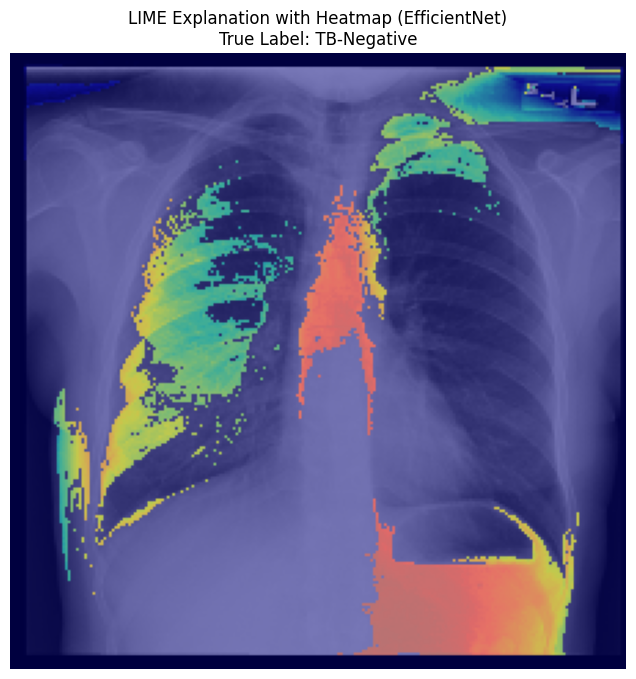

In [73]:
# Select a new image from the test dataset
image_index = 10  # Change this to the desired index
x_input = x_test[image_index:image_index + 1]  # Extract the image, keeping batch dimension
y_input = y_test[image_index]  # True label for the selected image

# Use the selected image for LIME explanation
image_to_explain = x_input[0]  # Ensure this is the correct input shape for your model

# Model Prediction using EfficientNet
prediction = model_efficientnet_cnn.predict(np.expand_dims(image_to_explain, axis=0))  # Add batch dimension
predicted_label = np.argmax(prediction)  # Get the class label (1 for TB, 0 for Not TB)

# Output Prediction
if predicted_label == 1:
    print("The model predicts this image is TB-positive.")
else:
    print("The model predicts this image is TB-negative.")

# Initialize the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Generate explanation for the input image
explanation = explainer.explain_instance(
    image_to_explain,
    model_efficientnet_cnn.predict,
    top_labels=2,  # Assuming TB and Not TB are the only two labels
    hide_color=0,
    num_samples=1000  # Number of perturbations
)

# Get explanation mask and heatmap values
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],  # Top label (predicted class)
    positive_only=True,  # Show only positive regions
    num_features=10,  # Increase number of features for wider highlights
    hide_rest=False  # Include the rest of the image
)

# Create a heatmap by combining the image with the mask
heatmap = np.zeros_like(temp, dtype=np.float32)
for i in range(3):  # Apply mask to each channel (R, G, B)
    heatmap[..., i] = mask * temp[..., i]

# Normalize the heatmap and apply a colormap
heatmap_normalized = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
heatmap_colored = plt.cm.jet(heatmap_normalized[..., 0])  # Apply colormap (jet)

# Overlay the heatmap on the original image
overlay = temp / 255.0 * 0.5 + heatmap_colored[..., :3] * 0.5  # Blend the image and heatmap

# Display the heatmap overlay
plt.figure(figsize=(8, 8))
plt.title(f"LIME Explanation with Heatmap (EfficientNet)\nTrue Label: {'TB-Positive' if y_input == 1 else 'TB-Negative'}")
plt.imshow(overlay)
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
The model predicts this image is TB-negative.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

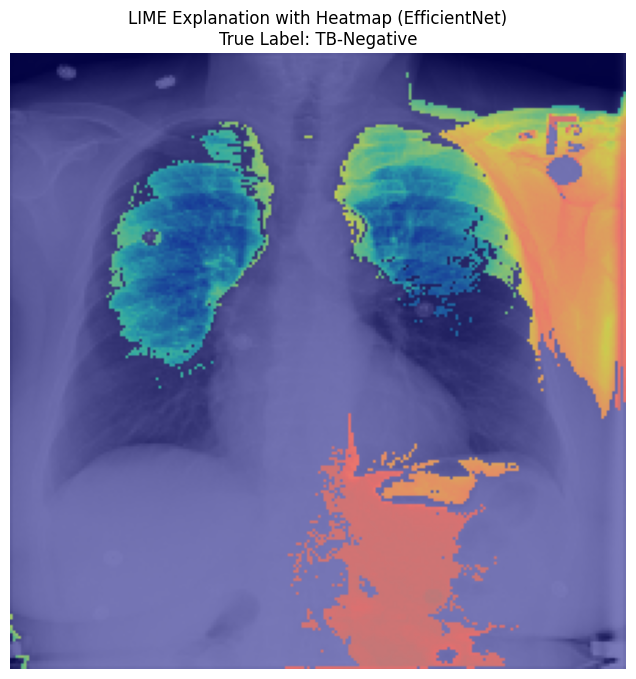

In [77]:
# Select a new image from the test dataset
image_index = 3  
x_input = x_test[image_index:image_index + 1]  # Extract the image, keeping batch dimension
y_input = y_test[image_index]  # True label for the selected image

# Use the selected image for LIME explanation
image_to_explain = x_input[0]  # Ensure this is the correct input shape for your model

# Model Prediction using EfficientNet
prediction = model_efficientnet_cnn.predict(np.expand_dims(image_to_explain, axis=0))  # Add batch dimension
predicted_label = np.argmax(prediction)  # Get the class label (1 for TB, 0 for Not TB)

# Output Prediction
if predicted_label == 1:
    print("The model predicts this image is TB-positive.")
else:
    print("The model predicts this image is TB-negative.")

# Initialize the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Generate explanation for the input image
explanation = explainer.explain_instance(
    image_to_explain,
    model_efficientnet_cnn.predict,
    top_labels=2,  # Assuming TB and Not TB are the only two labels
    hide_color=0,
    num_samples=1000  # Number of perturbations
)

# Get explanation mask and heatmap values
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],  # Top label (predicted class)
    positive_only=True,  # Show only positive regions
    num_features=10,  # Increase number of features for wider highlights
    hide_rest=False  # Include the rest of the image
)

# Create a heatmap by combining the image with the mask
heatmap = np.zeros_like(temp, dtype=np.float32)
for i in range(3):  # Apply mask to each channel (R, G, B)
    heatmap[..., i] = mask * temp[..., i]

# Normalize the heatmap and apply a colormap
heatmap_normalized = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
heatmap_colored = plt.cm.jet(heatmap_normalized[..., 0])  # Apply colormap (jet)

# Overlay the heatmap on the original image
overlay = temp / 255.0 * 0.5 + heatmap_colored[..., :3] * 0.5  # Blend the image and heatmap

# Display the heatmap overlay
plt.figure(figsize=(8, 8))
plt.title(f"LIME Explanation with Heatmap (EfficientNet)\nTrue Label: {'TB-Positive' if y_input == 1 else 'TB-Negative'}")
plt.imshow(overlay)
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

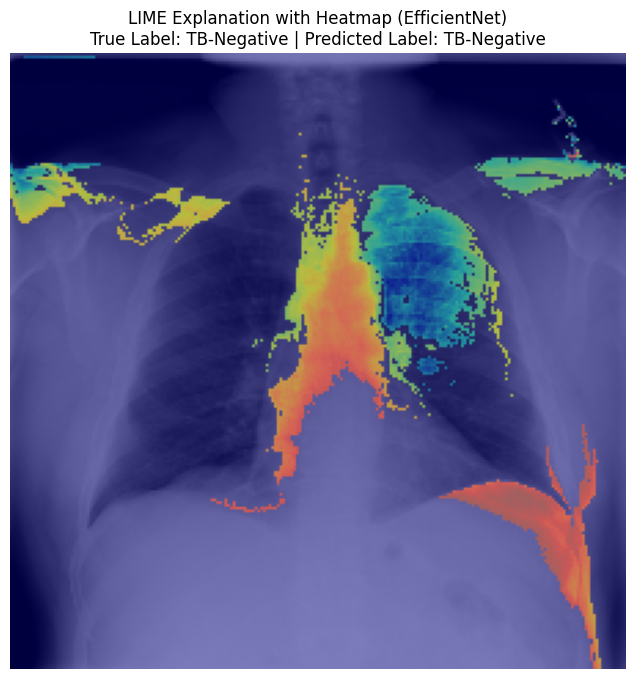

In [80]:
# Select a new image from the test dataset
image_index = 0 # Change this to the desired index
x_input = x_test[image_index:image_index + 1]  # Extract the image, keeping batch dimension
y_input = y_test[image_index]  # True label for the selected image

# Use the selected image for LIME explanation
image_to_explain = x_input[0]  # Ensure this is the correct input shape for your model

# Model Prediction using EfficientNet
prediction = model_efficientnet_cnn.predict(np.expand_dims(image_to_explain, axis=0))  # Add batch dimension
predicted_label = np.argmax(prediction)  # Get the class label (1 for TB, 0 for Not TB)

# Output Prediction
if predicted_label == 1:
    predicted_text = "TB-Positive"
else:
    predicted_text = "TB-Negative"

# Initialize the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Generate explanation for the input image
explanation = explainer.explain_instance(
    image_to_explain,
    model_efficientnet_cnn.predict,
    top_labels=2,  # Assuming TB and Not TB are the only two labels
    hide_color=0,
    num_samples=1000  # Number of perturbations
)

# Get explanation mask and heatmap values
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],  # Top label (predicted class)
    positive_only=True,  # Show only positive regions
    num_features=10,  # Increase number of features for wider highlights
    hide_rest=False  # Include the rest of the image
)

# Create a heatmap by combining the image with the mask
heatmap = np.zeros_like(temp, dtype=np.float32)
for i in range(3):  # Apply mask to each channel (R, G, B)
    heatmap[..., i] = mask * temp[..., i]

# Normalize the heatmap and apply a colormap
heatmap_normalized = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
heatmap_colored = plt.cm.jet(heatmap_normalized[..., 0])  # Apply colormap (jet)

# Overlay the heatmap on the original image
overlay = temp / 255.0 * 0.5 + heatmap_colored[..., :3] * 0.5  # Blend the image and heatmap

# Display the heatmap overlay with predicted and true labels
plt.figure(figsize=(8, 8))
plt.title(f"LIME Explanation with Heatmap (EfficientNet)\n"
          f"True Label: {'TB-Positive' if y_input == 1 else 'TB-Negative'} | Predicted Label: {predicted_text}")
plt.imshow(overlay)
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

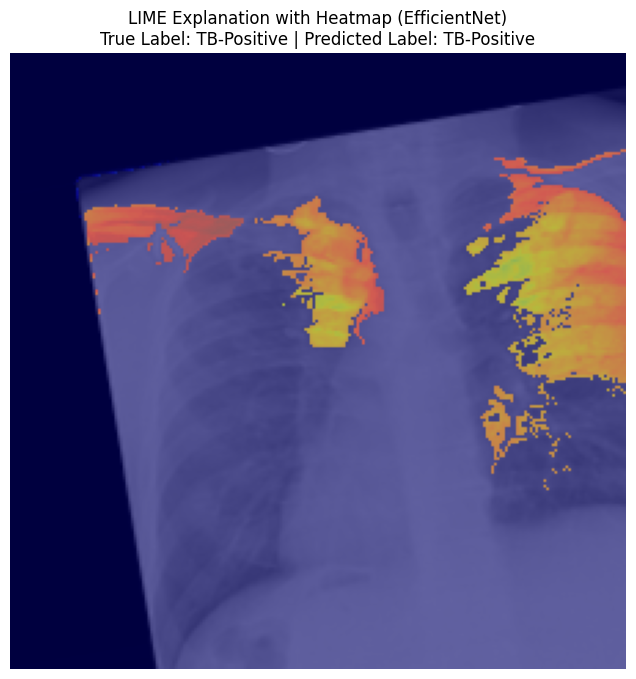

In [104]:
# Select a new image from the test dataset
image_index = 1 # Change this to the desired index
x_input = x_test[image_index:image_index + 1]  # Extract the image, keeping batch dimension
y_input = y_test[image_index]  # True label for the selected image

# Use the selected image for LIME explanation
image_to_explain = x_input[0]  # Ensure this is the correct input shape for your model

# Model Prediction using EfficientNet
prediction = model_efficientnet_cnn.predict(np.expand_dims(image_to_explain, axis=0))  # Add batch dimension
predicted_label = np.argmax(prediction)  # Get the class label (1 for TB, 0 for Not TB)

# Output Prediction
if predicted_label == 1:
    predicted_text = "TB-Positive"
else:
    predicted_text = "TB-Negative"

# Initialize the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Generate explanation for the input image
explanation = explainer.explain_instance(
    image_to_explain,
    model_efficientnet_cnn.predict,
    top_labels=2,  # Assuming TB and Not TB are the only two labels
    hide_color=0,
    num_samples=1000  # Number of perturbations
)

# Get explanation mask and heatmap values
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],  # Top label (predicted class)
    positive_only=True,  # Show only positive regions
    num_features=10,  # Increase number of features for wider highlights
    hide_rest=False  # Include the rest of the image
)

# Create a heatmap by combining the image with the mask
heatmap = np.zeros_like(temp, dtype=np.float32)
for i in range(3):  # Apply mask to each channel (R, G, B)
    heatmap[..., i] = mask * temp[..., i]

# Normalize the heatmap and apply a colormap
heatmap_normalized = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
heatmap_colored = plt.cm.jet(heatmap_normalized[..., 0])  # Apply colormap (jet)

# Overlay the heatmap on the original image
overlay = temp / 255.0 * 0.5 + heatmap_colored[..., :3] * 0.5  # Blend the image and heatmap

# Display the heatmap overlay with predicted and true labels
plt.figure(figsize=(8, 8))
plt.title(f"LIME Explanation with Heatmap (EfficientNet)\n"
          f"True Label: {'TB-Positive' if y_input == 1 else 'TB-Negative'} | Predicted Label: {predicted_text}")
plt.imshow(overlay)
plt.axis('off')
plt.show()
